In [18]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# File paths (Update these paths as per your system)
customers_file = "Customers.csv"
products_file = "Products.csv"
transactions_file = "Transactions.csv"

# Loading datasets
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)
transactions = pd.read_csv(transactions_file)

# Merge datasets to create a unified view
data = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")

# Preview data
print("Merged Dataset Preview:")
display(data.head())


Merged Dataset Preview:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [19]:
# Aggregating customer-level features
customer_profiles = data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    total_quantity=("Quantity", "sum"),
    transaction_count=("TransactionID", "nunique"),
    favorite_category=("Category", lambda x: x.mode()[0]),  # Most common category
).reset_index()

# Merging region information
customer_profiles = customer_profiles.merge(customers[["CustomerID", "Region"]], on="CustomerID", how="left")

# One-hot encode the "Region" and "favorite_category"
customer_profiles_encoded = pd.get_dummies(customer_profiles, columns=["Region", "favorite_category"])

# Scaling numeric features for similarity computation
scaler = StandardScaler()
numeric_features = ["total_spent", "avg_transaction_value", "total_quantity", "transaction_count"]
customer_profiles_encoded[numeric_features] = scaler.fit_transform(customer_profiles_encoded[numeric_features])

# Display the processed dataset
print("Processed Customer Profiles:")
display(customer_profiles_encoded.head())


Processed Customer Profiles:


,CustomerID,total_spent,avg_transaction_value,total_quantity,transaction_count,Region_Asia,Region_Europe,Region_North America,Region_South America,favorite_category_Books,favorite_category_Clothing,favorite_category_Electronics,favorite_category_Home Decor
0,C0001,-0.061701,-0.070263,-0.122033,-0.011458,False,False,False,True,False,False,True,False
1,C0002,-0.877744,-0.934933,-0.448000,-0.467494,True,False,False,False,False,True,False,False
2,C0003,-0.405857,-0.026271,0.203934,-0.467494,False,False,False,True,False,False,False,True
3,C0004,1.032547,-0.076769,1.670787,1.356650,False,False,False,True,True,False,False,False
4,C0005,-0.783929,-0.040028,-0.936951,-0.923530,True,False,False,False,False,False,True,False


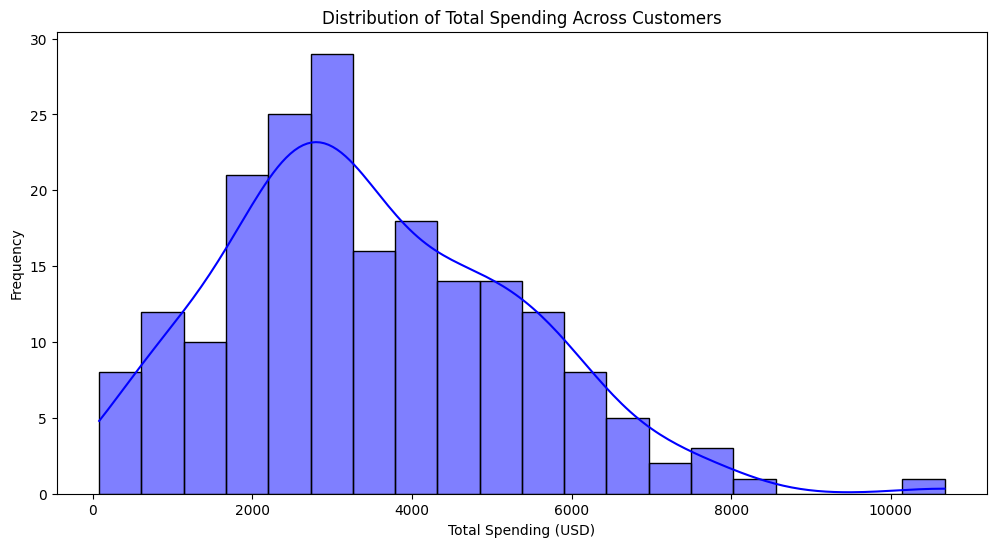

In [20]:
# Spending Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=customer_profiles, x="total_spent", kde=True, color="blue", bins=20)
plt.title("Distribution of Total Spending Across Customers")
plt.xlabel("Total Spending (USD)")
plt.ylabel("Frequency")
plt.show()


In [21]:
# Calculating cosine similarity
features = customer_profiles_encoded.drop(columns=["CustomerID"])
similarity_matrix = cosine_similarity(features)

# Create a DataFrame for cosine similarity
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles["CustomerID"], columns=customer_profiles["CustomerID"])

# Function to find top N similar customers
def get_top_n_similar(customer_id, similarity_df, n=3):
    similarities = similarity_df.loc[customer_id].sort_values(ascending=False)
    return similarities.iloc[1 : n + 1].index.tolist(), similarities.iloc[1 : n + 1].values.tolist()

# Get top 3 lookalikes for the first 20 customers
lookalike_map = {}
for customer_id in customer_profiles["CustomerID"][:20]:
    similar_customers, scores = get_top_n_similar(customer_id, similarity_df)
    lookalike_map[customer_id] = list(zip(similar_customers, scores))


In [22]:
# Flattening the lookalike map for CSV
lookalike_flat = [{"CustomerID": cust_id, "Lookalikes": lookalikes} for cust_id, lookalikes in lookalike_map.items()]
lookalike_df = pd.DataFrame(lookalike_flat)

# Save to CSV
output_file = "FirstName_LastName_Lookalike.csv"
lookalike_df.to_csv(output_file, index=False)
print(f"Lookalike recommendations saved to {output_file}")


Lookalike recommendations saved to FirstName_LastName_Lookalike.csv


C:\Users\yasas\AppData\Local\Temp\ipykernel_16724\3747927679.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[cust[0] for cust in sample_lookalikes], y=[cust[1] for cust in sample_lookalikes], palette="viridis")


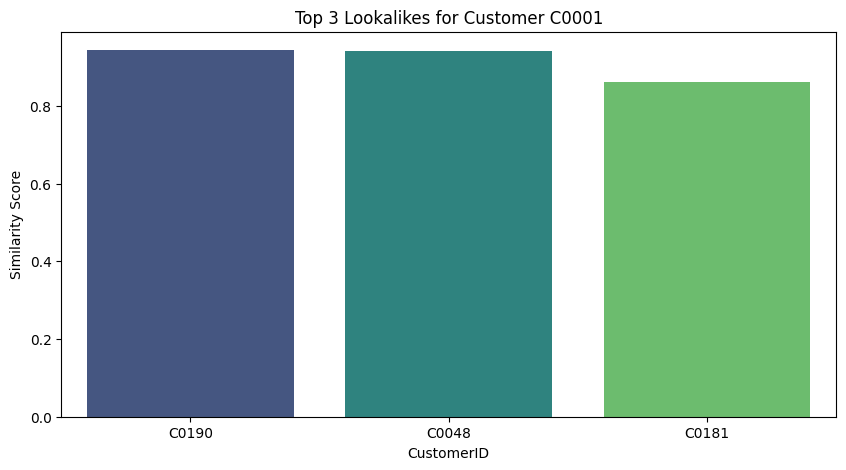

In [23]:
# Visualizing Lookalikes for a Sample Customer
sample_customer = list(lookalike_map.keys())[0]
sample_lookalikes = lookalike_map[sample_customer]

# Bar Plot of Similarity Scores
plt.figure(figsize=(10, 5))
sns.barplot(x=[cust[0] for cust in sample_lookalikes], y=[cust[1] for cust in sample_lookalikes], palette="viridis")
plt.title(f"Top 3 Lookalikes for Customer {sample_customer}")
plt.xlabel("CustomerID")
plt.ylabel("Similarity Score")
plt.show()


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, RobustScaler

# File paths (update these paths based on your environment)
customers_file = "Customers.csv"
products_file = "Products.csv"
transactions_file = "Transactions.csv"

# Load datasets
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)
transactions = pd.read_csv(transactions_file)

# Merge datasets into a single view
data = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")

# Check merged dataset
print(f"Dataset Shape: {data.shape}")
print("Sample Data:")
display(data.head())

Dataset Shape: (1000, 13)
Sample Data:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [25]:
# Aggregate customer-level features
customer_profiles = data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    total_quantity=("Quantity", "sum"),
    transaction_count=("TransactionID", "nunique"),
    product_diversity=("ProductID", "nunique"),  # Number of unique products purchased
    favorite_category=("Category", lambda x: x.mode()[0]),  # Most common product category
    first_purchase_date=("TransactionDate", "min"),
    last_purchase_date=("TransactionDate", "max")
).reset_index()

# Calculate customer tenure (days since first purchase)
customer_profiles["tenure_days"] = (
    pd.to_datetime(customer_profiles["last_purchase_date"]) - pd.to_datetime(customer_profiles["first_purchase_date"])
).dt.days

# Add region and demographic info
customer_profiles = customer_profiles.merge(customers[["CustomerID", "Region"]], on="CustomerID", how="left")

# One-hot encode categorical variables
customer_profiles_encoded = pd.get_dummies(customer_profiles, columns=["Region", "favorite_category"], drop_first=True)

# Drop unnecessary columns
customer_profiles_encoded.drop(columns=["first_purchase_date", "last_purchase_date"], inplace=True)

# Preview processed data
print("Processed Customer Profiles:")
display(customer_profiles_encoded.head())

Processed Customer Profiles:


,CustomerID,total_spent,avg_transaction_value,total_quantity,transaction_count,product_diversity,tenure_days,Region_Europe,Region_North America,Region_South America,favorite_category_Clothing,favorite_category_Electronics,favorite_category_Home Decor
0,C0001,3354.52,670.904,12,5,5,288,False,False,True,False,True,False
1,C0002,1862.74,465.685,10,4,4,278,False,False,False,True,False,False
2,C0003,2725.38,681.345,14,4,4,188,False,False,True,False,False,True
3,C0004,5354.88,669.360,23,8,8,299,False,False,True,False,False,False
4,C0005,2034.24,678.080,7,3,3,233,False,False,False,False,True,False


In [26]:
# Initialize the scaler
scaler = RobustScaler()  # Better handles outliers compared to StandardScaler

# List of numerical features to scale
numerical_features = ["total_spent", "avg_transaction_value", "total_quantity", "transaction_count", "product_diversity", "tenure_days"]

# Scale numerical features
customer_profiles_encoded[numerical_features] = scaler.fit_transform(customer_profiles_encoded[numerical_features])

# Check scaled data
print("Scaled Numerical Features:")
display(customer_profiles_encoded[numerical_features].head())

Scaled Numerical Features:


,total_spent,avg_transaction_value,total_quantity,transaction_count,product_diversity,tenure_days
0,0.083146,-0.022065,0.000000,0.000000,0.000000,0.417062
1,-0.488815,-0.740411,-0.235294,-0.333333,-0.333333,0.322275
2,-0.158072,0.014483,0.235294,-0.333333,-0.333333,-0.530806
3,0.850101,-0.027469,1.294118,1.000000,1.000000,0.521327
4,-0.423060,0.003054,-0.588235,-0.666667,-0.666667,-0.104265


In [27]:
# Calculate cosine similarity
features = customer_profiles_encoded.drop(columns=["CustomerID"])
similarity_matrix = cosine_similarity(features)

# Create a DataFrame for similarity
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profiles["CustomerID"], columns=customer_profiles["CustomerID"])

# Function to get top N similar customers
def get_top_n_similar(customer_id, similarity_df, n=3):
    similarities = similarity_df.loc[customer_id].sort_values(ascending=False)
    return similarities.iloc[1 : n + 1].index.tolist(), similarities.iloc[1 : n + 1].values.tolist()

# Generate lookalikes for the first 20 customers
lookalike_map = {}
for customer_id in customer_profiles["CustomerID"][:20]:
    similar_customers, scores = get_top_n_similar(customer_id, similarity_df)
    lookalike_map[customer_id] = list(zip(similar_customers, scores))

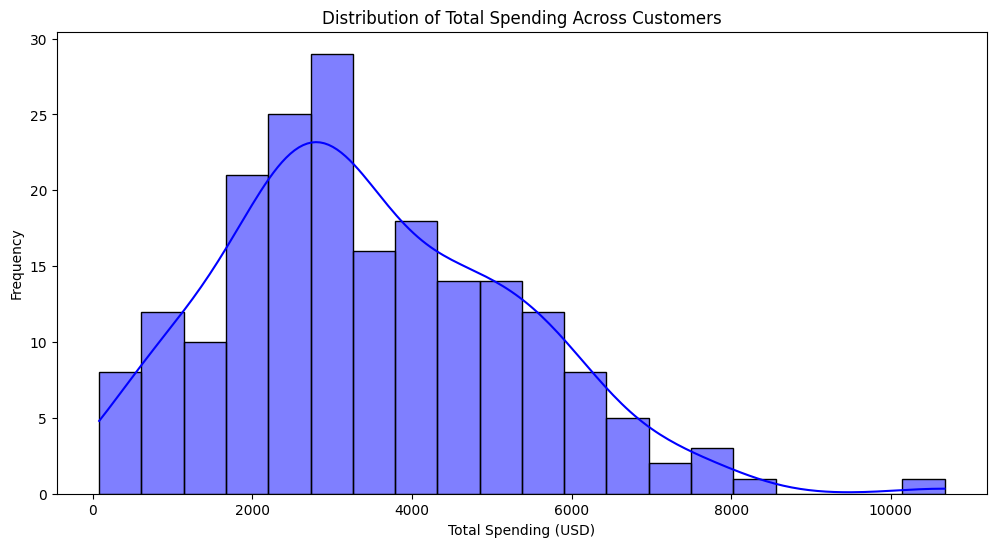

C:\Users\yasas\AppData\Local\Temp\ipykernel_16724\35788386.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[cust[0] for cust in sample_lookalikes], y=[cust[1] for cust in sample_lookalikes], palette="mako")


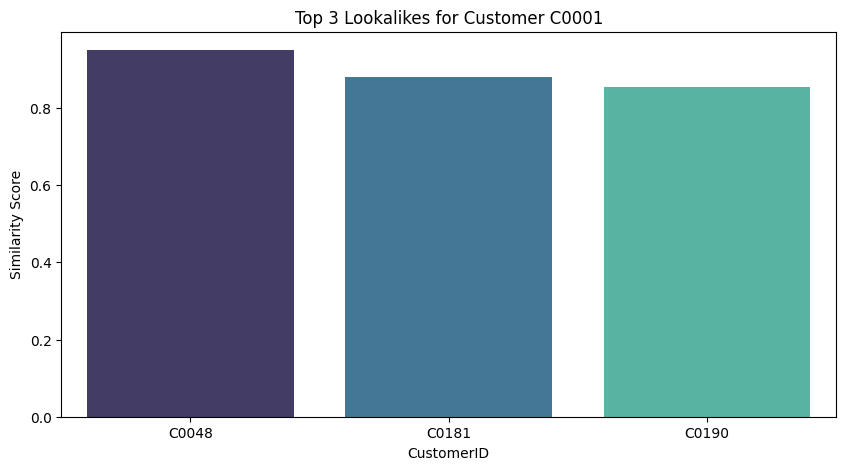

In [28]:
# Spending distribution
plt.figure(figsize=(12, 6))
sns.histplot(customer_profiles["total_spent"], kde=True, color="blue", bins=20)
plt.title("Distribution of Total Spending Across Customers")
plt.xlabel("Total Spending (USD)")
plt.ylabel("Frequency")
plt.show()

# Sample lookalike visualization
sample_customer = list(lookalike_map.keys())[0]
sample_lookalikes = lookalike_map[sample_customer]

# Bar plot for similarity scores
plt.figure(figsize=(10, 5))
sns.barplot(x=[cust[0] for cust in sample_lookalikes], y=[cust[1] for cust in sample_lookalikes], palette="mako")
plt.title(f"Top 3 Lookalikes for Customer {sample_customer}")
plt.xlabel("CustomerID")
plt.ylabel("Similarity Score")
plt.show()

In [29]:
# Flatten lookalike map for CSV output
lookalike_flat = [{"CustomerID": cust_id, "Lookalikes": lookalikes} for cust_id, lookalikes in lookalike_map.items()]
lookalike_df = pd.DataFrame(lookalike_flat)

# Save to CSV
output_file = "FirstName_LastName_Lookalike.csv"
lookalike_df.to_csv(output_file, index=False)
print(f"Lookalike recommendations saved to {output_file}")

Lookalike recommendations saved to FirstName_LastName_Lookalike.csv
